# Efficient Frontier

Efficient frontier is the set of optimal portfolios in this scatter plot, which is the visualization of modern portfolio theory (MPT), or mean-variance analysis. A theory which Harry Markowitz introduced in 1952, and was award a Nobel Memorial Prize in Economic Sciences Prize in 1990.

As obtaining the historical daily return in order to fit in CAPM, the information of daily return and the covariance between stocks are vaulable. Efficient Froniter tries to find the combination of allocating our asset that can generate **the highest expected return** with **the lowest expected risk**.

Let's dive in!!!

In [1]:
from function.func import load_ERm,load_ERi,load_Rf
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import random
import seaborn as sns
import matplotlib.pyplot as plt

/opt/anaconda3/envs/stock/lib/python3.10/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


## Load in our target stock

In [2]:
# list the candidate stock
candidates = ['9910','3008','2330','2395','5871'] 

In [3]:
# create a day span dataframe template
end_date = datetime.today().date()
start_date = end_date - timedelta(days=365*7)
dnt_range = pd.date_range(start_date,end_date,freq='D')
df_day_span = pd.DataFrame(dnt_range,columns=['date'])
df_all = pd.DataFrame(dnt_range,columns=['date'])

In [4]:
# concatenate and align stocks into a dataframe
stock_dict = {}
div_dict = {}
for candidate in candidates:
    stockprice, div_dict_can = load_ERi(candidate)
    stockprice = pd.merge(stockprice,df_day_span,left_on='date',right_on='date')
    df_day_span = stockprice[['date']]
    div_dict.update(div_dict_can)
    stockprice[f'return annualised {candidate}'] = stockprice['close'].pct_change(periods=1).values * 250
    df_all = pd.merge(df_all,stockprice[['date',f'return annualised {candidate}']],left_on='date',right_on='date')

ERi - 9910 loading...
ERi - 3008 loading...
ERi - 2330 loading...
ERi - 2395 loading...
ERi - 5871 loading...


## Ex-Dividend merges into return

At the ex-dividend date, the stock price would drop according the amount of dividend, and the gap of price becomes the return back to our budget. We should not ignore the return of dividend although we have already filtered out the daily return at the ex-dividend date. 

Therefore, as we make the annualised return, we add on the dividend to this. We now consider not only the return of price going up and down but also the annual bonus(dividend) while investing that stock.

In [5]:
# add dividend to our annualised return according to the yearly divident record. 
for candidate, div in div_dict.items():
    for year, div_val in div.items():
        new_val = df_all[df_all['date'].apply(lambda x: x.strftime('%Y')) == year][f'return annualised {candidate}'] + div_val/100
        if len(new_val) != 0:
            df_all.loc[df_all['date'].apply(lambda x: x.strftime('%Y')) == year,f'return annualised {candidate}'] = new_val

## Step-by-step visualisation 

Mean-variance analysis for **target stocks**

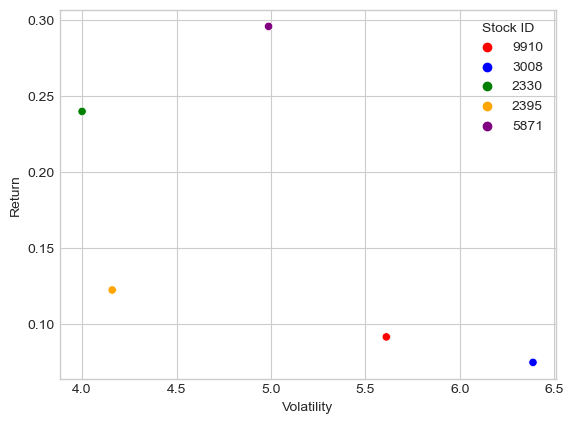

In [6]:
cov_matrix = df_all.iloc[1:,:].cov()
mean =  df_all.iloc[1:,1:].mean().values

var = np.diag(cov_matrix)
sd = np.sqrt(var) # Daily standard deviation
variation = sd    # Annual standard deviation = volatility

df_plot = pd.DataFrame({'Stock ID': candidates,
 'Return': mean,
 'Volatility':variation})

plt.style.use("seaborn-whitegrid")

colors = ["r","b","g",'orange','purple']
sns.set_palette(sns.color_palette(colors))

sns.scatterplot(df_plot,x='Volatility', y='Return',hue='Stock ID')
plt.savefig(f'img/scatter_ef_ori.png',dpi=300)
#plt.show()

Mean-variance analysis for **target stocks** + **a equal weight combination point**

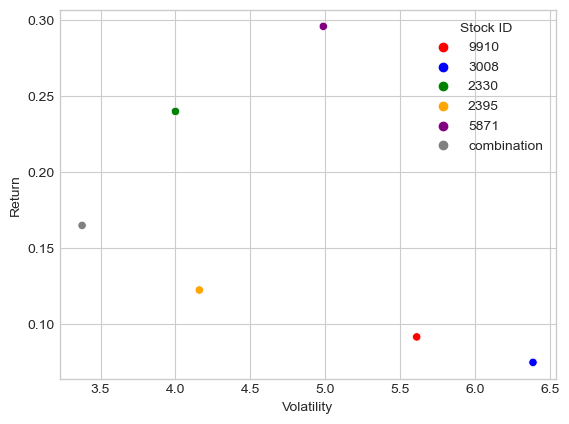

In [7]:
weight = [0.2,0.2,0.2,0.2,0.2]
var = cov_matrix.mul(weight, axis=0).mul(weight, axis=1).sum().sum()
combin_variation = np.sqrt(var)
combin_mean = np.dot(weight, mean)

df_plot_combination = pd.DataFrame({'Stock ID': 'combination',
 'Return': [combin_mean],
 'Volatility':[combin_variation]})

df_plot2 = pd.concat([df_plot,df_plot_combination],axis=0)

plt.style.use("seaborn-whitegrid")
colors = ["r","b","g",'orange','purple','grey']
sns.set_palette(sns.color_palette(colors))

sns.scatterplot(df_plot2,x='Volatility', y='Return',hue='Stock ID')
plt.savefig(f'img/scatter_ef_3basic_1con.png',dpi=300)
#plt.show()

Mean-variance analysis for **target stocks** + **100 random weight combination points**

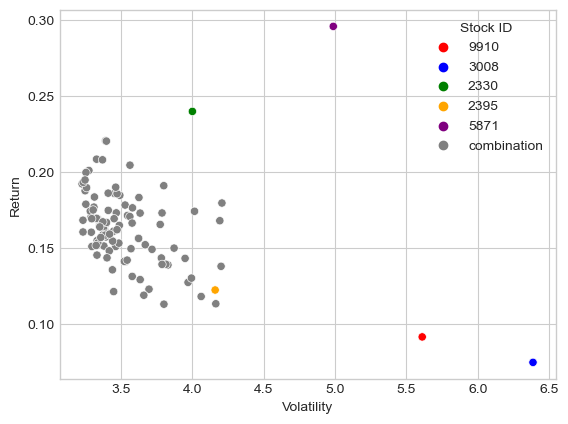

In [8]:
random.seed(11)
combin_means = [] # Define an empty array for portfolio returns
combin_variations = [] # Define an empty array for portfolio volatility
weights = [] # Define an empty array for asset weights
num_assets = len(df_plot)
num_portfolios = 100

for portfolio in range(num_portfolios):
    weight = np.random.random(num_assets)
    weight = weight/np.sum(weight)
    weights.append(weight)
    combin_mean = np.dot(weight, mean) # Returns are the product of individual expected returns of asset and its 
    combin_means.append(combin_mean)
    
    var = cov_matrix.mul(weight, axis=0).mul(weight, axis=1).sum().sum()# Portfolio Variance
    combin_variation = np.sqrt(var)
    combin_variations.append(combin_variation)
    
df_plot_combination = pd.DataFrame({'Stock ID': 'combination',
 'Return': np.array(combin_means),
 'Volatility':np.array(combin_variations)})

df_plot2 = pd.concat([df_plot,df_plot_combination],axis=0)

plt.style.use("seaborn-whitegrid")
colors = ["r","b","g",'orange','purple','grey']
sns.set_palette(sns.color_palette(colors))
sns.scatterplot(df_plot2,x='Volatility', y='Return',hue='Stock ID')
plt.savefig(f'img/scatter_ef_points_{num_portfolios}.png',dpi=300)
#plt.show()

Mean-variance analysis for **target stocks** + **1000 random weight combination points**

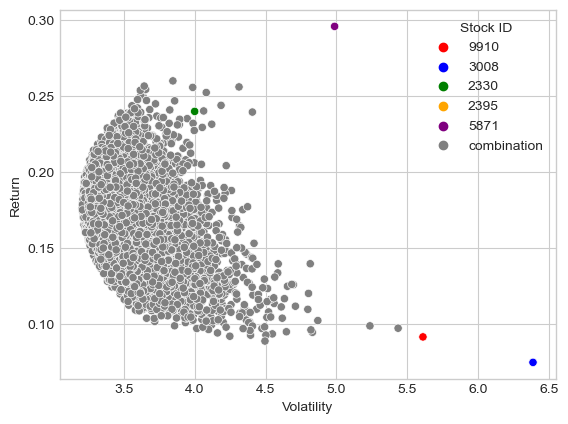

In [9]:
random.seed(11)
combin_means = [] # Define an empty array for portfolio returns
combin_variations = [] # Define an empty array for portfolio volatility
weights = [] # Define an empty array for asset weights
num_assets = len(df_plot)
num_portfolios = 10000

for portfolio in range(num_portfolios):
    weight = np.random.random(num_assets)
    weight = weight/np.sum(weight)
    weights.append(weight)
    combin_mean = np.dot(weight, mean) # Returns are the product of individual expected returns of asset and its 
    combin_means.append(combin_mean)
    
    var = cov_matrix.mul(weight, axis=0).mul(weight, axis=1).sum().sum()# Portfolio Variance
    combin_variation = np.sqrt(var)
    combin_variations.append(combin_variation)
    
df_plot_combination = pd.DataFrame({'Stock ID': 'combination',
 'Return': np.array(combin_means),
 'Volatility':np.array(combin_variations)})

df_plot2 = pd.concat([df_plot,df_plot_combination],axis=0)

plt.style.use("seaborn-whitegrid")
colors = ["r","b","g",'orange','purple','grey']
sns.set_palette(sns.color_palette(colors))
sns.scatterplot(df_plot2,x='Volatility', y='Return',hue='Stock ID')
plt.savefig(f'img/scatter_ef_points_{num_portfolios}.png',dpi=300)
#plt.show()

## Optimal investment combination 

There of them are all on the marginal curve in the scatter plot. Maximum return and minimum risk are easy to find, simply push the curve the top point (maximum return) or the left point (minimum risk). Nonetheless, the most popular is the balance point on efficient frontier. 


To find it, we introduce [Sharpe Ratio](https://www.investopedia.com/terms/s/sharperatio.asp), the average return earned by increasing per unit of risk. The point with the highest Sharpe Ratio accordingly has the highest return at the lowest risk.

Frist we include our risk-free profolio: **Risk-free rate (Rf)**

In [10]:
Rf = load_Rf()

Rf loading...


Mean-variance analysis including **RF**

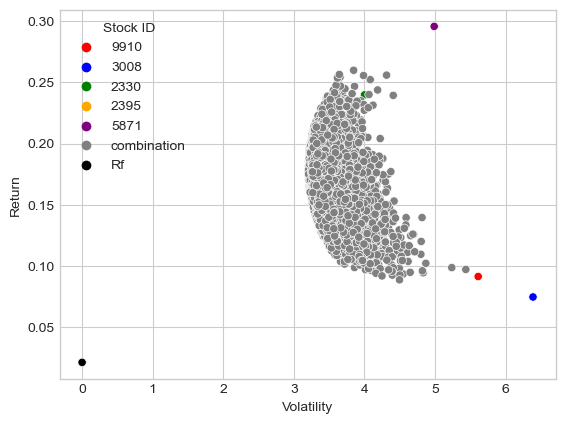

In [11]:
Rf_mean = (Rf['value'].values/100).mean()
Rf_variations = 0
df_plot_Rf = pd.DataFrame({'Stock ID': 'Rf',
 'Return': [Rf_mean],
 'Volatility':[Rf_variations]})

df_plot3 = pd.concat([df_plot2,df_plot_Rf],axis=0)

plt.style.use("seaborn-whitegrid")
colors = ["r","b","g",'orange','purple','grey','black']
sns.set_palette(sns.color_palette(colors))
sns.scatterplot(df_plot3,x='Volatility', y='Return',hue='Stock ID')
plt.savefig(f'img/scatter_ef_points_{num_portfolios}_Rf.png',dpi=300)
plt.show()

Calcuate Sharpe Ratio for each point on plot, and query the point with maximum Sharpe Ratio. Finally plot it on our scatter plot

In [12]:
# Calculate Sharpe Ratio 
SR_all_points = (df_plot2.Return.values - Rf_mean)/df_plot2.Volatility.values

In [13]:
SR_max = np.max(SR_all_points)
x = df_plot2.Return.values[np.argmax(SR_all_points)]
y = df_plot2.Volatility.values[np.argmax(SR_all_points)]
SR_max_point = df_plot2.loc[(df_plot2['Return']==x)&(df_plot2['Volatility']==y)].replace('combination','max sharpe ratio')

In [14]:
SR_max_point.replace('combination','max sharpe ratio')

,Stock ID,Return,Volatility
9808,max sharpe ratio,0.256457,3.644216


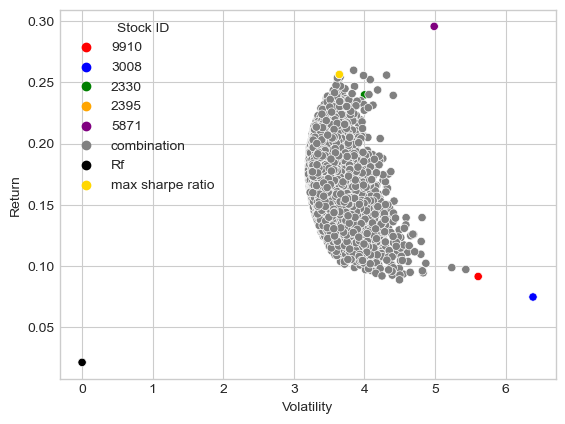

In [15]:
df_plot4 = pd.concat([df_plot3,SR_max_point],axis=0)

plt.style.use("seaborn-whitegrid")
colors = ["r","b","g",'orange','purple','grey','black','gold']
sns.set_palette(sns.color_palette(colors))
sns.scatterplot(df_plot4,x='Volatility', y='Return',hue='Stock ID')
plt.savefig(f'img/scatter_ef_points_{num_portfolios}_Rf_maxSR.png',dpi=300)
plt.show()

Draw a [Capital Market Line (CML)](https://www.investopedia.com/terms/c/cml.asp), which should penetrate `max sharpe ratio` point and form a tangent line on efficient frontier.

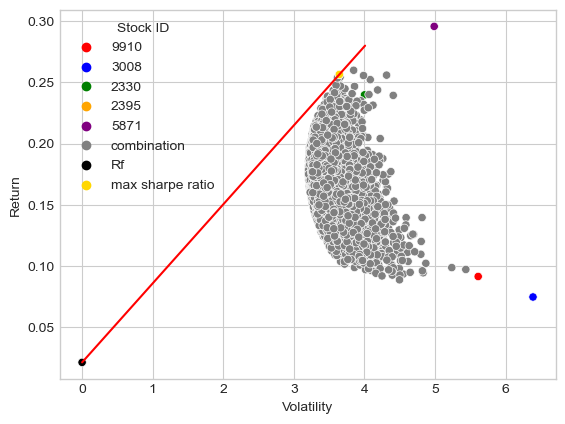

In [16]:
xlim = Rf_variations + 1.1*(SR_max_point.Volatility.values[0] - Rf_variations)
ylim = Rf_mean + 1.1*(SR_max_point.Return.values[0] - Rf_mean)

plt.style.use("seaborn-whitegrid")
colors = ["r","b","g",'orange','purple','grey','black','gold']
sns.set_palette(sns.color_palette(colors))
sns.scatterplot(df_plot4,x='Volatility', y='Return',hue='Stock ID')
plt.plot([Rf_variations, xlim], [Rf_mean,ylim])

plt.savefig(f'img/scatter_ef_points_{num_portfolios}_Rf_maxSR_CML.png',dpi=300)
plt.show()

Create a table of best weight allocation/combination of each target stock: **Best Portfolio**

In [17]:
# query the best weight point
z = zip(weights,combin_means,combin_variations)
for w, m, v in list(z) :
    if m == SR_max_point.Return.values[0] and v == SR_max_point.Volatility.values[0]:
        print(f'Best weight allocation: {w}')
        break

Best weight allocation: [0.00601993 0.01057175 0.55373778 0.02725532 0.40241522]


In [18]:
pd.DataFrame({'Stock ID':candidates, 'Asset Allocation':w})

,Stock ID,Asset Allocation
0,9910,0.006020
1,3008,0.010572
2,2330,0.553738
3,2395,0.027255
4,5871,0.402415
